In [1]:
import numpy as np
import math
import pandas as pd
import scipy.spatial.distance as dis
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy.random as rand
import scipy.stats as stats
import scipy.misc as misc
import scipy.special as special
from collections import Counter
#certain of these functions imported according to section code

In [1]:
! wget -o - "http://mcb112.org/w06/w06-data.tbl" > 'out.txt'

In this project, I use RNA-seq data which is clearly clustered into five cell-type groupings, and implement hard k-means and mixture model algorithms from first principles to cluster the data into the correct clusters.

In [3]:
with open ('w06-data.tbl', 'r') as f:
    celltype = []
    points = []
    for line in f:
        if line[0] == '#':
            continue
        columns = line.split()
        celltype.append(int(columns[1]))
        points.append([int(columns[2]), int(columns[3])])
    

In [4]:
points_arr = np.array(points)
cmax, cmin = np.max(points_arr, axis=0), np.min(points_arr, axis=0)

In [5]:
#takes in data and centroids, calculates the minimum distance between each point and each center, and then assigns each point to the closest centroid. 
#These functions are inspired by the code from section
def assign(points, centers):
    distances = []
    clusters = []
    
    #calculates Euclidean distance between all points and centroids, then assigns to the cluster with the lowest distance 
    for i in range(len(points)):
        temp_dist = np.min([math.sqrt((points[i][0]-center[0])**2 + (points[i][1]-center[1])**2) for center in centers])
        temp_cluster = np.argmin([math.sqrt((points[i][0]-center[0])**2 + (points[i][1]-center[1])**2) for center in centers])
        distances.append(temp_dist)
        clusters.append(temp_cluster)
    distance = sum(distances)
    
    #counts number of clusters with nonzero values
    c = Counter(clusters)
    centers = dict.fromkeys([0, 1, 2, 3, 4], 0)

    #check to see if clusters have zero points assigned to them
    for element in c:
        centers[element] = c[element]
    empties = []
    for key in centers:
        if centers[key] == 0:
            empties.append(key)
            
    #assign points with farthest distances to empty clusters (1 point per empty cluster)
    for x in empties:
        max_idx = np.argmax(distances)
        distances[max_idx] = 0
        clusters[max_idx] = x
    return clusters, distance

def update(points, clusters, num_clust):
    
    #updates centers by taking the average of distances between a centroid and each of its points 
    points = np.asarray(points)
    new_centers = []
    for x in range(num_clust):
        avg_kiwi = 0
        avg_caraway = 0
        kiwi_temp = []
        caraway_temp = []
        for i in range(len(clusters)):
            if clusters[i] == x:
                avg_kiwi += points[i][1]
                avg_caraway += points[i][0]
                kiwi_temp.append(points[i][1])
                caraway_temp.append(points[i][0])
        avg_kiwi, avg_caraway = avg_kiwi/len(kiwi_temp), avg_caraway/len(caraway_temp)
        new_centers.append([avg_caraway, avg_kiwi])
    return new_centers

    #get the mean of the points that share each cluster, update centroids

Having defined all necessary functions, I now implement the K-means model. Instead of starting with random centroid values, I initialize centroids by randomly picking points from my data. 

In [6]:
#This process was inspired by the code we used in section

K = 5
num_iterations = 20

kiwi = points_arr[:, 1]
caraway = points_arr[:, 0]
min_dist = float('inf')

best_centers = []
best_clusters = []

for i in range(num_iterations):
    
    #chooses centroid values as random choices from the data points
    centroid_kiwi = np.random.choice(kiwi, size=5)
    centroid_caraway = np.random.choice(caraway, size=5)
    centers = list(zip(centroid_caraway, centroid_kiwi))
    last_clusters = [1]*len(points_arr)
    clusters = [0]* len(points_arr)
    
    #update until the clusertings don't change
    while last_clusters != clusters: 

        last_clusters = clusters

        #assigns points to new centers
        clusters, distance = assign(points_arr, centers)

        #takes average of distances, finds new centers
        centers = update(points_arr, clusters, K)
    
    #Stores best distance, centers, and clusterings
    if distance < min_dist:
        min_dist = distance
        best_centers = centers
        best_clusters = clusters
    
    #This allows us to watch the minimum distance decrease to keep us entertained while the program is running :) 
    #print(min_dist)

507437.159485008
507437.159485008
507437.159485008
506518.1689582501
506518.1689582501
506518.1689582501
506518.1689582501
506518.1689582501
504759.098971677
504759.098971677
504759.098971677
504759.098971677
504759.098971677
504759.098971677
504759.098971677
504759.098971677
504759.098971677
504759.098971677
504759.098971677
504759.098971677


One good statistic for reproducing the best K-means is to find the configuration that produces the minimum total distance of each point to its respective center. In the above code, I find this minimum totdist value over the course K-means algoriths starting with 20 different initial configurations.

In [7]:
print("After my K-means algorithm ran using with %i different starting configurations, the best total distance achieved is %.2f."%(num_iterations, min_dist))

After my K-means algorithm ran using with 20 different starting configurations, the best total distance achieved is 504759.10.


In [8]:
#These functions are adapted from the script given to us in the pset. I use the first two functions only at the end to verify my findings, and use an adapted version of visualize_data to plot my clustering.

def read_data(infile):

    ctype = []
    data  = []
    with open(infile) as f:
        for line in f:
            if line[0] == '#': continue   # skip comment lines
            fields = line.split()
            ctype.append(int(fields[1]))
            data.append( [int(fields[2]), int(fields[3])])  # assumes exactly 2 genes!!
    ctype = np.array(ctype)
    data  = np.array(data)
    N, G  = np.shape(data)
    Q     = np.max(ctype) + 1
    return ctype, data, N, G, Q


def initialize_at_true():

    qp = np.array([ 0.1, 0.2, 0.4, 0.2, 0.1 ])
    mu = np.array([[   30., 2000. ],
                   [ 2000., 2000. ],
                   [  300.,  300. ],
                   [   30.,   30. ],
                   [ 2000,    30. ]])
    return mu, qp


def visualize_data(data, mu, C):

    N, G  = np.shape(data)
    Q, G2 = np.shape(mu)
    assert G == G2
    assert len(C) == N

    # We can assign colors to up to Q=10 components.
    colormap = ['xkcd:orange', 'xkcd:olive',     'xkcd:azure',    'xkcd:rose', 'xkcd:mustard', 
                'xkcd:peach',  'xkcd:turquoise', 'xkcd:lavender', 'xkcd:rust', 'xkcd:red']

    fig, ax = plt.subplots(figsize=(8,5))
    for i in range(N):
        edgecolor = colormap[ C[i]]
        fillcolor = 'w'
        shape     = 'o'
        ax.loglog( data[i][0], data[i][1], marker=shape, mec=edgecolor, mfc=fillcolor, mew=1.5)

    for q in range(Q):
        ax.loglog(mu[q][0], mu[q][1], '*k', ms=10)

    ax.set_xlabel('caraway (counts)')
    ax.set_ylabel('kiwi (counts)')

    plt.show()


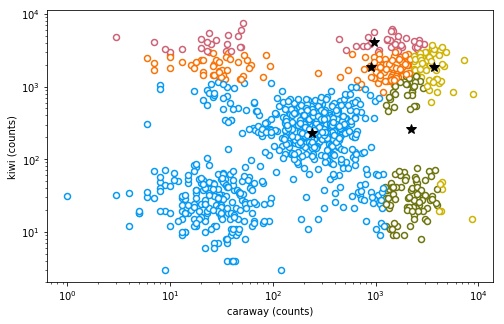

In [9]:

visualize_data(points_arr, best_centers, best_clusters)


The above plot shows clustering according to my k-means algorithm on raw RNA-seq data. We can see that on raw data, a hard k-means algorithm doesn't cluster correctly into the 5 clearly visible grouping. This is due to the fact that RNA-seq data is likely log-normally or negative binomially distributed, meaning that if we want to use a k-means algorithm, which implicitly assumes normality, we must first log transform our data. Below, I redo this k-means approach using log transformed expression data. First, however, I implement a negative binomial mixture model algorithm, which more flexibly clusters the data becasue it does not base its clusters on Euclidean distance, but rather on likelihood.

Another method to improve these results is to use a soft k-means approach/mixture model. Thus, shown below are results from clustering, first using a mixture model  

However, we should notice that the scale of the graph is logarithmic on both axes, meaning that each unit of uniform distance on the graph actually corresponds to larger and larger distances as one moves away from the origin. Thus, it would make sense that the cluster closest to the origin would seem to include a disproportionately large number of points in that area - these points, while seemingly too far away to be assigned to the same cluster, are 'actually' closer togther than they seem. However, we know that from Figure 2, showing the true clustering of the cells, that regardless of this logarithmic scale, the true clustering matches with our initial intuition that the cells should be grouped into the five clusters as they appear to the eye. This makes sense, because if the data are only distributed normally in logspace, then even proportionately large differences in transcription between cells with low absolute transcription would be overshadowed by even small variations in transcription from cells with high baseline trasncription. In problem 3, I discuss potential fixes to this issue with my K-means algorithm.

# Problem 2

In [11]:
def expectation(points, mus, phi, mix_coeffs):
#Calculates expectation step

    log_posts = []
    for point in points:
        temp = []
        for i in range(len(mus)):
            #we assume kiwi and caraway levels are independent
            temp.append(np.log(mix_coeffs[i]) + stats.nbinom.logpmf(point[0], 1/phi, 1/(1+mus[i][0]*phi)) + stats.nbinom.logpmf(point[1], 1/phi, 1/(1+mus[i][1]*phi)))
        denominator = special.logsumexp(temp)
        
        #Normalization step
        log_posts.append(temp - denominator)
    posteriors = np.exp(log_posts)    
    clusters = []
    
    #Assign clusters
    for post in posteriors:
        clusters.append(np.argmax(post))

    return posteriors, clusters

def maximization(points, posts, mix_coeffs):
#Performs maximization step

    mus = []
    mix_coeffs_new = []
    for i in range(len(mix_coeffs)):
        caraway_temp = 0
        kiwi_temp = 0
        mix_temp = 0
        temp = []
        
        #Calculates new centers and mixture coefficients
        for j in range(len(points)):
            caraway_temp += points[j][0]*posts[j][i]
            kiwi_temp += points[j][1]*posts[j][i]
            mix_temp += posts[j][i]

        temp.append(caraway_temp/mix_temp) 
        temp.append(kiwi_temp/mix_temp)

        mus.append(temp)
        mix_coeffs_new.append(mix_temp/len(points))

    return mus, mix_coeffs_new

def neg_log_likelihood(points, mus, phi, mix_coeffs):
    #Calculates the negative log likelihood
    ll = []
    for i in range(len(mix_coeffs)):
        for point in points:            
            ll.append(np.log(mix_coeffs[i])+stats.nbinom.logpmf(point[0], 1/phi, 1/(1+mus[i][0]*phi))+stats.nbinom.logpmf(point[1], 1/phi, 1/(1+mus[i][1]*phi)))
    print(-np.sum(ll))
    return (-np.sum(ll))

Having define all necessary functions, I can now implement my mixture negative binomial model.

In [ ]:
#This process inspired by the section code.
num_iterations = 10
num_clust = 5

#Can make this threshhold lower if desired. For the sake of time, however, 0.01 should work without too much loss in accuracy.
nll_threshhold = 0.01
phi = 0.3

min_dist = float('inf')
mus_best = []*len(points_arr)
nll_best = float('inf')
mix_coeffs_best = []
posteriors_final = []*len(points_arr)

for i in range(num_iterations):
    #gets starting mixture coefficients
    coeff_choices = np.random.rand(num_clust)
    mix_coeffs = np.divide(coeff_choices, sum(coeff_choices))
    
    #gets starting centers
    centroid_kiwi = np.random.choice(kiwi, size=5)
    centroid_caraway = np.random.choice(caraway, size=5)
    mu_values = list(zip(centroid_caraway, centroid_kiwi))

    nll_diff = float('inf')
    nll_last = float(0)

    while nll_diff > abs(nll_threshhold*nll_last):
        #Expectation step, returns posteriors and clusterings.
        posteriors, clusters = expectation(points_arr, mu_values, phi, mix_coeffs)

        #Maximization step, returns updated mu values and mixture coefficients
        mu_values, mix_coeffs = maximization(points_arr, posteriors, mix_coeffs)
 
        #Calculated negative log likelihood
        nll = neg_log_likelihood(points_arr, mu_values, phi, mix_coeffs)        
        
        nll_diff = abs(nll-nll_last)
        nll_last = nll

    
    #Stored the mixture coefficients, clustering, and centroid data for the model with the lowest log likelihood value
    if nll < nll_best:
        
        mix_coeffs_best = mix_coeffs
        nll_best = nll
        mus_best = mu_values
        clusters_best = clusters
        posteriors_final = posteriors

434571.67568363284
375358.83141681744
347207.884556932
333933.87172834005
316212.80585571233


We can now visualize our best calculate mixture model

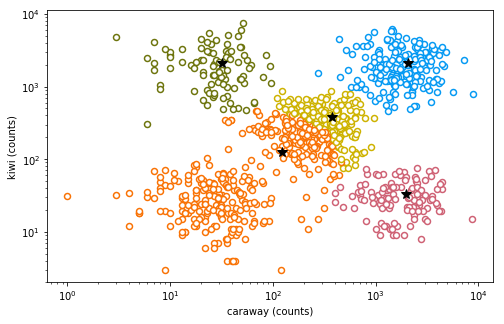

In [14]:
visualize_data(points_arr, mus_best, clusters_best)

In [15]:
print("The estimated mean expression of (caraway, kiwi) in the five cell types are (%i, %i), (%i, %i), (%i, %i), (%i, %i), and (%i, %i)."%(mus_best[0][0], mus_best[0][1], mus_best[1][0], mus_best[1][1], mus_best[2][0], mus_best[2][1], mus_best[3][0], mus_best[3][1], mus_best[4][0], mus_best[4][1]))

The estimated mean expression of (caraway, kiwi) in the five cell types are (123, 124), (31, 2129), (2060, 2117), (1960, 32), and (376, 376).


In [16]:
distances = []
for i in range(len(points_arr)):
    temp_dist = np.min([math.sqrt((points_arr[i][0]-mu[0])**2 + (points_arr[i][1]-mu[1])**2) for mu in mus_best])
    distances.append(temp_dist)
dist = sum(distances)
print(dist)

506458.3571375108


In [17]:
print("The total distance calculated using this mixture model is %.1f" %(dist))

The total distance calculated using this mixture model is 506458.4


Interestingly, the total distance using the mixture model is noticeably larger than the totdist measured in the standard K-means model. By eye, however, we can see that the clustering using the mixture model, while not perfect, is definitely more accurate. This indicates that total distance is not the most appropriate statistic for determining best fit in this case. For the mixture model, a more appropriate statistic would be the total likelihood P(X∣θ). For this problem in particular, as I will discuss more in problem 3, one of the issues with using total Euclidean distance is that our data are only distributed normally in logspace. Using likelihood as our determining statistic should account for this issue. If desired, we could caluclate the total likelihood P(X∣θ) by marginalizing the likelihood of belonging to q for every point x, then multiplying these likelihoods. In my model, I use the negative log likelihood as the best statistic. In this case, minimizing the negative log likelihood maximized the total likelihood of a given model.

# Problem 3

As discussed above, it is helpful to notice that, while the clustering of the data points looks normally distributed, this is actually not true since the axes on our plot are in log scale. Thus, moving one unit of graphical distance at a position close to the origin corresponds to a much smaller true change than a movement farther away from the origin. For example, moving from 10^0 to 10^1 corresponds to a difference of 9,  10^1 to 10^2 corresponds to a difference of 90, and 10^2 to 10^3 corresponds to a difference of 900. All such distances on our graph, however, appear the same. This realization explains why our initial K-means graph looks as it does; data points close to the origin have transcription levels that are orders of magnitude lower than the others, so those data points are largely assigned to a single centroid. In this way, small differences in transcription are erased, overshadowed by the transcription levels of higher orders of magnitude. Correspondingly, this creates a large cluster that includes an overrespresentation of the points closer to the origin. Thus, simply using Euclidean distance as a measure of clustering cannot successfully be used in this situation. 

One way that we can fix this is by first logtransforming our data (and conseuqently, our centroids), and only then using our standard K-means model. If our hypothesis is correct, then the data should be distributed normally in logspace, and by first log transforming the data, we should then successfully be able to use total Euclidean distance as a measure of best fit. 

However, first it would be helpful to visualize our initial K-means clustering on a graph that has regular, non-log axes, to get a better sense of how the data "actually" appears, or rather how our model is actually treating it.

In [18]:
def visualize_data_nonlog(data, mu, C):

    N, G  = np.shape(data)
    Q, G2 = np.shape(mu)
    assert G == G2
    assert len(C) == N

    colormap = ['xkcd:orange', 'xkcd:olive',     'xkcd:azure',    'xkcd:rose', 'xkcd:mustard', 
                'xkcd:peach',  'xkcd:turquoise', 'xkcd:lavender', 'xkcd:rust', 'xkcd:red']

    fig, ax = plt.subplots(figsize=(8,5))
    for i in range(N):
        edgecolor = colormap[ C[i]]
        fillcolor = 'w'
        shape     = 'o'
        ax.plot( data[i][0], data[i][1], marker=shape, mec=edgecolor, mfc=fillcolor, mew=1.5)

    for q in range(Q):
        ax.plot(mu[q][0], mu[q][1], '*k', ms=10)

    ax.set_xlabel('caraway (counts)')
    ax.set_ylabel('kiwi (counts)')

    plt.show()

For reference, I show below the result of my initial K-means test. Then, below, I show the same clustering on a graph with non-log axes.

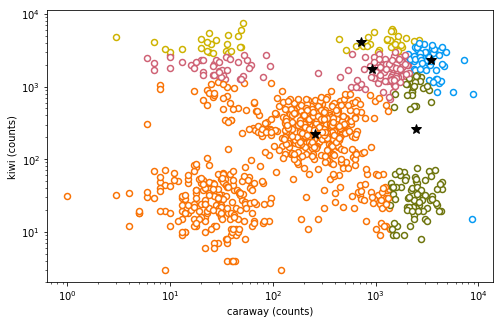

In [19]:
visualize_data(points_arr, best_centers, best_clusters)

Now for comparison, I plot the same graph on non-log axes.

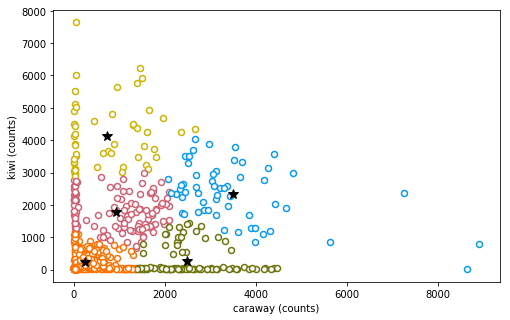

In [20]:
visualize_data_nonlog(points_arr, best_centers, best_clusters)

As seen in this graph, the clustering generated by the initial K-means actually looks quite good in terms of clustering absolute transcription levels. However, we can also see that the natural clusters we perceive in the graph with the log scale are gone, showing that clustering the data in this way is not the correct approach. 

Below, I perform the same K-means test again, except I first take the log of all of the data points (and centroids). Only once my K-means algorithm has run do I take the data out of log space and plot my clustering again on the log axes.

In [25]:
K = 5
num_iterations = 20

kiwi = points_arr[:, 1]
caraway = points_arr[:, 0]
log_kiwi = np.log10(kiwi)
log_caraway = np.log10(caraway)
min_dist = float('inf')

best_centers_exp = []
best_clusters_log = []
points_arr_log = np.log10(points_arr)

for i in range(num_iterations):
    centroid_kiwi = np.random.choice(log_kiwi, size=5)
    centroid_caraway = np.random.choice(log_caraway, size=5)
    centers = list(zip(centroid_caraway, centroid_kiwi))
    last_clusters = [1]*len(points_arr_log)
    clusters = [0]* len(points_arr_log)
    
    #update until clusters don't change
    while last_clusters != clusters: 
        last_clusters = clusters

        #assigns points to new centers
        clusters, distance = assign(points_arr_log, centers)

        #takes average of distances, finds new centers
        centers = update(points_arr_log, clusters, K)
    
    if distance < min_dist:
        min_dist = distance
        best_centers_log = centers
        best_clusters_exp = clusters

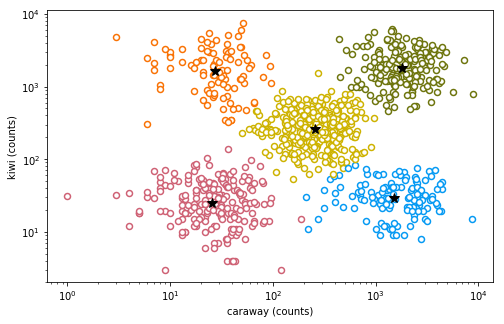

In [26]:
unlogged_points = np.power(10, points_arr_log)
unlogged_centers = np.power(10, best_centers_log)

visualize_data(unlogged_points, unlogged_centers, best_clusters_exp)

As we can see by eye, this method of K-means clustering by first logtransforming the data seems to have worked very well. The five clusters perceived by eye are clustered together, with centroids roughly at the center of each. Below, I show the figure that Moriarty developed showing the true clustering and centroids for purposes of comparison.

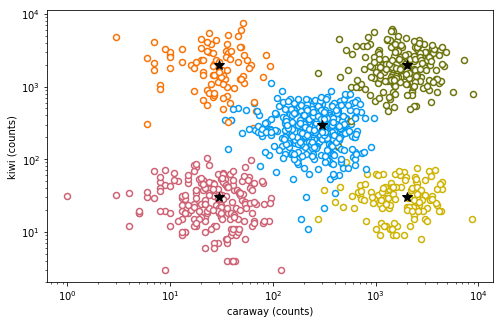

In [23]:
with open ('w06-data.tbl', 'r') as f:
    ctype, data, N, G, Q = read_data('w06-data.tbl')
    centroids, qp = initialize_at_true()
    visualize_data(data, centroids, ctype)

As we can see, my method of first log transforming the data worked remarkably well and achieved a result very similar to the true clustering. We can compare the true mu values to the ones generated in my experiment to get a better sense of how close my clustering came to the true clustering.

In [24]:
print("Using my updated K-means method, the mu values were:")
print(unlogged_centers)
print("The true mu values were:")
print(centroids)

Using my updated K-means method, the mu values were:
[[  27.2895879  1624.90135179]
 [ 258.11388533  262.43493217]
 [1501.94203787   28.84355833]
 [1796.30832183 1824.82954143]
 [  25.77287721   24.51765628]]
The true mu values were:
[[  30. 2000.]
 [2000. 2000.]
 [ 300.  300.]
 [  30.   30.]
 [2000.   30.]]


While not printed in the same order, the mu values my adapted K-means produced are very similar to the true centroid values. 

In the future, it would be very interesting to investigate how universally applicable this method of log-transforming before performing K-means is. On an intuitive level, this process makes sense - if different cell types express a gene at vastly different baselines, clustering based purely on absolute abundance wouldn't make sense because even small changes to a high baseline would dwarf proportionally large changes in the trancription from a low baseline. However, taking the log first could reveal more accurately relative differences of transcription levels of all magnitudes. Thus, exploring the conditions under which this new approach could be used would be worthwhile.